<a href="https://colab.research.google.com/github/h1m4/ai_deep_learning_study/blob/master/ai_theory/190121_MNIST_CNN_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np

from tensorflow.keras.datasets import mnist as dataset
from keras.utils import to_categorical
import tensorflow as tf

# Set Hyperparameter

In [0]:
num_classes = 10

learning_rate = 0.001 #  경사 하강법에서 학습 단계별로 움직이는 학습 속도를 정의
batch_size = 64 # 한 번 학습이 이루어지는 수
num_epochs = 10 # 전체 몇 번 돌릴 것인가

drop_rate = 0.5 # 전체 weight을 계산에 참여시키는 것이 아니라 layer에 포함된 weight 중에서 일부만 참여시키는 것이다. 

In [0]:
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

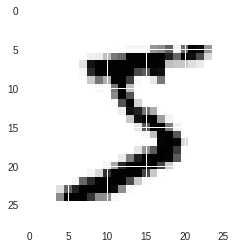

(28, 28)

In [27]:
plt.imshow(train_images[0])
plt.show()

train_images[0].shape # 2차원임

In [5]:
train_images.shape

(60000, 28, 28)

컨볼루션과 pooling의 차이점

* 컨볼루션은 하나를 줄이는 것, 풀링은 그렇게 줄인 것을 다층화시켜서 줄이는 것???????


컨볼루션 레이어 이외에 풀링(pooling) 레이어라고 불리우는 레이어가 콘볼루션 레이어 뒤에 따라 오는게 일반적입니다. 풀링 레이어는 콘볼루션 레이어의 출력 값을 단순하게 압축해주고 콘볼루션 레이어가 생산해낸 정보를 컴팩트한 버전으로 만들어 줍니다

In [0]:
# def build_model(input_shape):
# #      Convolution
#     inputs = tf.keras.layers.Input(input_shape)
    
#     conv = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
#                                   strides=(1, 1), padding='SAME',
#                                   name='conv_1')(inputs)
#     acts = tf.keras.layers.ReLU()(conv)
    
#     conv = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
#                                   strides=(1, 1), padding='SAME',
#                                   name='conv_2')(conv)
#     acts = tf.keras.layers.ReLU()(conv)
    
#     pool = tf.keras.layers.MaxPool2D()(acts)
    
# #     Fully Connected
#     drop = tf.keras.layers.Dropout(drop_rate)(pool) # 단순화 과정
#     flat = tf.keras.layers.Flatten()(drop) # 늘어뜨리는 과정
#     dense = tf.keras.layers.Dense(128, activation='relu')(flat) # 늘어난 노드의 갯수이자 이만큼 계산됨 
#     drop = tf.keras.layers.Dropout(drop_rate)(dense)
#     dense = tf.keras.layers.Dense(num_classes, activation='softmax')(drop)
    
#     return tf.keras.Model(inputs=inputs, outputs=dense)

In [0]:
def conv_block(inputs, filters=64, kernel_size=(3, 3), strides=(1, 1), name='conv'):
    conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  padding='SAME',
                                  name=name)(inputs)
    norm = tf.keras.layers.BatchNormalization()(conv) #  internal covariate shift를 줄이는 것이다. 신경망의 각 레이어의 분포를 같게함으로써 좀더 안정적인 학습이 가능하다.
    acts = tf.keras.layers.ReLU()(norm)
    return acts

def max_pooling(inputs, name='pool'): #  2×2 영역에서 가장 큰 값을 선택해서 정보를 압축합니다.
    return tf.keras.layers.MaxPool2D(name=name)(inputs)

'''
pooling을 convolution의 후속과정이 아닌 별도의 개념으로 정의합니다.
예를 들어 convolution을 matrix 연산에 의해 얻는 것이라면,
pooling은 matrix 연산을 사용하지 않고 각 pixel에서 하나의 값을 뽑아내는 과정으로도 이해할 수 있습니다.


relu : 올라가는 거...그래프...그거...반응?
'''

def build_model(input_shape):
    with tf.variable_scope("conv_layer"):
        inputs = tf.keras.layers.Input(input_shape)
        net = conv_block(inputs, filters=64, name='conv_1_1')
        net = conv_block(net, filters=64, name='conv_1_2')
        net = max_pooling(net, name='pool_1')

        net = conv_block(net, filters=128, name='conv_2_1')
        net = conv_block(net, filters=128, name='conv_2_2')
        net = max_pooling(net, name='pool_2')

        net = conv_block(net, filters=256, name='conv_3_1')
        net = conv_block(net, filters=256, name='conv_3_2')
        net = conv_block(net, filters=256, name='conv_3_3')
        net = max_pooling(net, name='pool_3')

        net = conv_block(net, filters=512, name='conv_4_1')
        net = conv_block(net, filters=512, name='conv_4_2')
        net = conv_block(net, filters=512, name='conv_4_3')
        net = max_pooling(net, name='pool_4')

        net = conv_block(net, filters=512, name='conv_5_1')
        net = conv_block(net, filters=512, name='conv_5_2')
        net = conv_block(net, filters=512, name='conv_5_3')
        net = max_pooling(net, name='pool_5')

    with tf.variable_scope("FC_layer"):
        net = tf.keras.layers.Flatten()(net)
        net = tf.keras.layers.Dense(4096, activation='relu')(net)
        net = tf.keras.layers.Dropout(drop_rate)(net)
        net = tf.keras.layers.Dense(4096, activation='relu')(net)
        net = tf.keras.layers.Dropout(drop_rate)(net)
        net = tf.keras.layers.Dense(num_classes, activation='softmax')(net)
    return tf.keras.Model(inputs=inputs, outputs=net)

# Optimization

In [0]:
model = build_model((28, 28, 1))
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate),
              loss='categorical_crossentropy', #손실은 한 가지 예에서 모델의 예측이 얼마나 잘못되었는지를 나타내는 수
              metrics=['accuracy'])

In [24]:
model.fit(x=np.expand_dims(train_images, -1), # expand_dims는 axis에 차원을 추가한다. -1의 경우 마지막에 차원을 추가함 원래 차원 x (28, 28)이라서 그런것
          y=to_categorical(train_labels, num_classes),
          epochs=int(num_epochs),
          batch_size=batch_size,
          validation_data = (np.expand_dims(test_images, -1), #?? dims가 뭐임
                             to_categorical(test_labels, num_classes)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 202us/step - loss: 9.0416 - acc: 0.4357 - val_loss: 6.1926 - val_acc: 0.6143
Epoch 2/10
60000/60000 [==============================] - 11s 187us/step - loss: 6.2463 - acc: 0.6104 - val_loss: 4.8063 - val_acc: 0.7008
Epoch 3/10
60000/60000 [==============================] - 11s 187us/step - loss: 5.3794 - acc: 0.6651 - val_loss: 3.8580 - val_acc: 0.7590
Epoch 4/10
60000/60000 [==============================] - 11s 181us/step - loss: 4.6743 - acc: 0.7091 - val_loss: 3.2370 - val_acc: 0.7985
Epoch 5/10
60000/60000 [==============================] - 11s 179us/step - loss: 4.3796 - acc: 0.7275 - val_loss: 2.9454 - val_acc: 0.8166
Epoch 6/10
60000/60000 [==============================] - 11s 183us/step - loss: 4.0427 - acc: 0.7485 - val_loss: 2.9121 - val_acc: 0.8191
Epoch 7/10
60000/60000 [==============================] - 11s 188us/step - loss: 3.9635 - acc: 0.7538 - val_loss: 2.